In [145]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [146]:
df = pd.read_csv('https://raw.githubusercontent.com/llimllib/bostonmarathon/master/results/2014/results.csv')

In [147]:
df.head(n=5)

,10k,name,division,25k,gender,age,official,bib,genderdiv,ctz,...,overall,pace,state,30k,5k,half,20k,country,city,40k
0,17.37,"Yamamoto, Hiroyuki",8,47.67,M,47,85.25,W1,8,NaN,...,8,3.27,NaN,59.18,8.02,39.72,37.65,JPN,Fukuoka,80.43
1,32.58,"Jeptoo, Rita",1,82.43,F,33,138.95,F1,1,NaN,...,21,5.30,NaN,99.33,16.22,69.47,65.83,KEN,Eldoret,132.10
2,16.62,"Van Dyk, Ernst F.",1,45.80,M,41,80.60,W2,1,NaN,...,1,3.08,NaN,56.45,7.75,38.03,36.10,RSA,Paarl,76.10
3,32.57,"Dibaba, Mare",3,82.43,F,24,140.58,F2,3,NaN,...,27,5.37,NaN,99.33,16.20,69.47,65.83,ETH,Shoa,132.95
4,17.12,"Hokinoue, Kota",2,46.37,M,40,81.23,W3,2,NaN,...,2,3.10,NaN,57.03,8.02,38.60,36.58,JPN,Nogata Fukuoka,76.72


In [148]:
df.columns

Index(['10k', 'name', 'division', '25k', 'gender', 'age', 'official', 'bib',
       'genderdiv', 'ctz', '35k', 'overall', 'pace', 'state', '30k', '5k',
       'half', '20k', 'country', 'city', '40k'],
      dtype='object')

In [149]:
df.isna().sum()

10k              0
name             0
division         0
25k              0
gender           0
age              0
official         0
bib              0
genderdiv        0
ctz          30740
35k              0
overall          0
pace             0
state         2576
30k              0
5k               0
half             0
20k              0
country          0
city             1
40k              0
dtype: int64

In [150]:
# Drop columns not needed
df = df.drop(columns=['name', 'bib', 'ctz', 'state', 'country', 'city'])

# Remove hyphens 
df = df.replace(to_replace='-', value='')

# Convert columns to numeric values
cols = ['10k', '25k', '35k', '30k', '5k', 'half', '20k', '40k' ]
for col in cols:
    df[col] = pd.to_numeric(df[col])

# Drop missing data
df = df.dropna()

In [151]:
# Make Binary Indicators for age groups
df['Under 30'] = df['age'] <= 30
df['Over 60'] = df['age'] >= 60

In [152]:
# Collect new dataframe with only variables of interest
data = df[['5k','10k','20k','35k','40k','Under 30','Over 60','official','overall']]

In [153]:
# Split data into test and training set (done to reduce memory requirements)
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size=0.90, random_state=42)

# Normalize smaller dataset
X_n = normalize(train)

In [154]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.model_selection import cross_val_score

# K-Means

In [155]:
# Run k means model
for k in np.arange(2, 5, 1):
    model = KMeans(n_clusters=k, random_state=42).fit(X_n)
    labels = model.labels_
    silhouette = metrics.silhouette_score(X_n, labels, metric='euclidean')
    print('K: {}, silhouette: {}'.format(k, silhouette))

K: 2, silhouette: 0.9412489759858577
K: 3, silhouette: 0.8690701122634232
K: 4, silhouette: 0.8512007477148933


# Mean Shift

In [156]:
from sklearn.cluster import MeanShift, estimate_bandwidth

# Estimate Bandwidth
bandwidth = estimate_bandwidth(X_n, quantile=0.2, n_samples=1000)

# Fit Model
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X_n)

# Get labels, number of clusters, similarity score
labels = ms.labels_
n_clusters = len(np.unique(labels))
silhouette = metrics.silhouette_score(X_n, labels, metric='euclidean')
print('K: {}, silhouette: {}'.format(n_clusters, silhouette))

K: 27, silhouette: 0.7905549219858956


# Spectral Clustering

In [157]:
from sklearn.cluster import SpectralClustering

# Run spectral clustering for multiple k values
for k in np.arange(2, 5, 1):
    sc = SpectralClustering(n_clusters=k, random_state=42).fit(X_n)
    labels = model.labels_
    silhouette = metrics.silhouette_score(X_n, labels, metric='euclidean')
    print('K: {}, silhouette: {}'.format(k, silhouette))

K: 2, silhouette: 0.8512007477148933
K: 3, silhouette: 0.8512007477148933
K: 4, silhouette: 0.8512007477148933


In [158]:
# K means model with 2 components seems to be the best

In [159]:
# Perform PCA on data
pca = PCA(n_components=2)
pca_X = pca.fit(X_n).transform(X_n)

# Get cluster assignments
model = KMeans(n_clusters=2, random_state=42).fit(X_n)
labels = model.labels_
train['cluster'] = labels

c:\users\halln\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


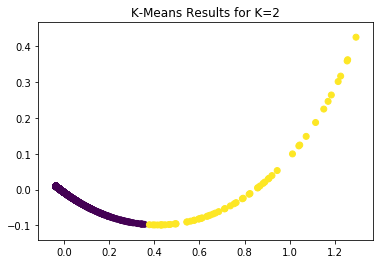

In [160]:
# Plot PCA components and clusters
plt.scatter(pca_X[:, 0], pca_X[:, 1], c=train['cluster'])
plt.title('K-Means Results for K=2')
plt.show()

In [161]:
# Group results by cluster
train.groupby(['cluster'])['overall'].describe()

,count,mean,std,min,25%,50%,75%,max
cluster,,,,,,,,
0,3103.0,16446.474380,9066.209613,617.0,8416.0,16583.0,24495.0,31874.0
1,61.0,273.590164,157.389684,2.0,166.0,262.0,384.0,578.0


In [162]:
# Summary stats, gender distribution by cluster
train.groupby(['cluster'])['Under 30'].describe()

,count,unique,top,freq
cluster,,,,
0,3103,2,False,2540
1,61,2,True,34


In [163]:
# Summary stats, gender distribution by cluster
train.groupby(['cluster'])['Over 60'].describe()

,count,unique,top,freq
cluster,,,,
0,3103,2,False,2865
1,61,1,False,61


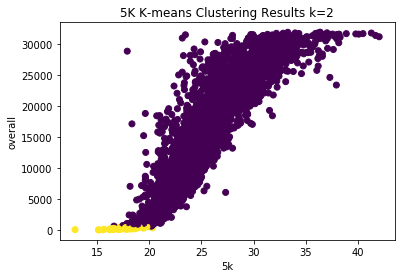

In [164]:
# Plot 5k split vs overall finish
plt.scatter(train['5k'], train['overall'], c=train['cluster'])
plt.xlabel('5k')
plt.ylabel('overall')
plt.title('5K K-means Clustering Results k=2')
plt.show()

majority of the data is contained in cluster 0 and cluster 1 has much lower values than cluster 0.  Cluster 1 also contains mostly people under 30.  This clustering solution seems to just identify the fastest runners but doesent really show any other information.